In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
from utide._ut_constants import ut_constants as utide
import os
from utils import *
import pandas as pd
import cartopy.feature as cfeature
import xesmf as xe
from scipy.ndimage import gaussian_filter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from palette import *



# useful variables
j=np.complex(0,1)
cpd=2.*np.pi/86400. # from cpd to radian/s
crs = ccrs.PlateCarree() # cartopy


#datadir = './'
datadir = '/home/cercache/users/cgonzale/data/test/'
graphdir = '/home3/homedir7/perso/cgonzale/IWAVE/figures/'
bathy = '/home2/pharos/othr/aponte/bathy/ETOPO2v2c_f4.nc'
datadir_tides = '/home2/pharos/othr/aponte/tides/HRET/'
datadir_tides2 = '/home2/pharos/othr/aponte/tides/FES2014/'
# tmp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

palette = '/home3/homedir7/perso/cgonzale/IWAVE/script/palette/medspiration.rgb'
csst = getColorMap( rgbFile = palette )

In [2]:
#compute gradients of SST for a day with more than one image 
Region = 'AustraliaHW'
day = '20160908'
#day = '20160909' #grad temporal

#Region = 'Equator'
#day = '20140217'

#Region = 'Mozamb2'
##day = '20140606'
#day = '20140605'
zoomer = False
#day = '20140604'

year_folder = day[0:4]
day_folder = date_to_nth_day(day)
print(year_folder,day_folder)

2016 252


In [3]:
#Read csv with all available SST images for the region
path_available_files = datadir+ 'Available_images_LOG' + os.sep
name_file = Region + '_available_SST_images.csv'

#may check if the file already exist otherwise call available_SST_images.py to create it

SST_files = pd.read_csv(path_available_files+name_file, sep='\t')

In [4]:
dfile = SST_files.loc[SST_files['date'].isin([day])]
print(dfile)

     Unnamed: 0      date                                               path
873           0  20160908  /home/cercache/users/cgonzale/data/test/Austra...
874           0  20160908  /home/cercache/users/cgonzale/data/test/Austra...
875           0  20160908  /home/cercache/users/cgonzale/data/test/Austra...
876           0  20160908  /home/cercache/users/cgonzale/data/test/Austra...
877           0  20160908  /home/cercache/users/cgonzale/data/test/Austra...


In [5]:
list_file = dfile['path'].values.tolist()


In [6]:
#read and merge all files
ds = xr.merge([xr.open_dataset(f) for f in list_file]) 

In [7]:
print(ds)

<xarray.Dataset>
Dimensions:                      (lat: 601, lon: 1001, time: 5)
Coordinates:
  * time                         (time) datetime64[ns] 2016-09-08T01:28:03 ...
  * lat                          (lat) float32 -24.01 -23.99 -23.97 -23.95 ...
  * lon                          (lon) float32 105.01 105.03 105.05 105.07 ...
Data variables:
    quality_level                (time, lat, lon) float64 nan nan nan nan ...
    sea_surface_temperature      (time, lat, lon) float64 nan nan nan nan ...
    sst_dtime                    (time, lat, lon) float64 -9.223e+18 ...
    satellite_zenith_angle       (time, lat, lon) float64 nan nan nan nan ...
    sses_bias                    (time, lat, lon) float64 nan nan nan nan ...
    sses_standard_deviation      (time, lat, lon) float64 nan nan nan nan ...
    brightness_temperature_4um   (time, lat, lon) float64 nan nan nan nan ...
    brightness_temperature_11um  (time, lat, lon) float64 nan nan nan nan ...
    brightness_temperature_12um  (

In [8]:
Nt = ds.dims['time']
it = np.arange(Nt)
it = np.linspace(0,Nt-1,num = Nt)
print(it)

[0. 1. 2. 3. 4.]


In [9]:
print(ds.time)

<xarray.DataArray 'time' (time: 5)>
array(['2016-09-08T01:28:03.000000000', '2016-09-08T13:58:03.000000000',
       '2016-09-08T17:40:14.000000000', '2016-09-08T17:41:39.000000000',
       '2016-09-08T17:43:05.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2016-09-08T01:28:03 2016-09-08T13:58:03 ...
Attributes:
    long_name:      reference time of field
    standard_name:  time
    axis:           T


In [10]:
t = ds['sea_surface_temperature']-273.15

In [11]:
if (Region == 'Mozamb2' or 'MozambS') and zoomer:
    latmin_z = -27
    latmax_z = -26
    lonmin_z = 45
    lonmax_z = 46
    vmin = 20
    vmax = 27
    vmax_grad = 0.2
    vmax_tw=0.1
    it=0
else:
    latmin_z = -30
    latmax_z = -24
    lonmin_z = 42
    lonmax_z = 48
    vmin = 20
    vmax = 27
    vmax_grad = 0.2
    vmax_tw=0.1
    
if (Region == 'Mozamb4'):
    latmin_z = -14 #-14,-13
    latmax_z = -12#-12, -7
    lonmin_z =  52#52,49
    lonmax_z =  55#55,53

if (Region == 'AustraliaHW'):
    latmin_z = -22 #-14,-13
    latmax_z = -12#-12, -7
    lonmin_z =  114#52,49
    lonmax_z =  124#55,53
    vmin = 22
    vmax = 29
    vmax_grad = 0.1
    vmax_tw=0.05
    if (day == '20160908'):
        it =2
        it01,it02 = 3,4
    if (day == '20160909'):
        it =0
        it01,it02 = 1,0

if (Region == 'Equator'):
    latmin_z = -10
    latmax_z = 10
    lonmin_z =  -150#52,49
    lonmax_z =  -120
    vmin = 24
    vmax = 29
    vmax_grad = 0.1
    vmax_tw=0.05
  

toplt_zoom = t.where(t['lon']>=lonmin_z, drop=True)
toplt_zoom = toplt_zoom.where(toplt_zoom['lon']<=lonmax_z, drop=True)
toplt_zoom = toplt_zoom.where(toplt_zoom['lat']<=latmax_z, drop=True)
toplt_zoom = toplt_zoom.where(toplt_zoom['lat']>=latmin_z, drop=True)

img_extent = (lonmin_z, lonmax_z, latmin_z, latmax_z)

In [12]:
toplt_zoom.time

<xarray.DataArray 'time' (time: 5)>
array(['2016-09-08T01:28:03.000000000', '2016-09-08T13:58:03.000000000',
       '2016-09-08T17:40:14.000000000', '2016-09-08T17:41:39.000000000',
       '2016-09-08T17:43:05.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2016-09-08T01:28:03 2016-09-08T13:58:03 ...
Attributes:
    long_name:      reference time of field
    standard_name:  time
    axis:           T

3
(114, 124, -22, -12)


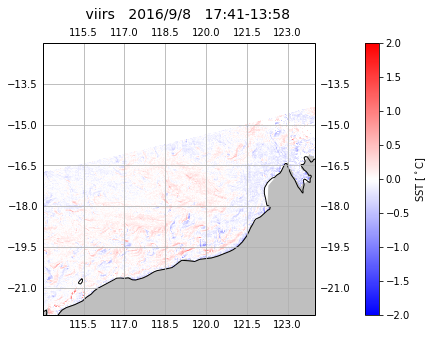

In [13]:
if(Region == 'AustraliaHW'):
    if(day == '20160909'):
        it2 = 4
        it1 = 2
        it4 = 5
        it3 = 1
        irange1 = 2
        irange2 = 2 
        i01=1
        i02 = 4
        dt_Temp3 = toplt_zoom[5,:,:]-toplt_zoom[it1,:,:]
        
        
    if(day == '20160908'):
        it2 = 3
        it1 = 1
        it4 = 4
        it3 = 1
        irange1 = 1
        irange2 = 3
        i01=1
        i02 = 2
        dt_Temp3 = toplt_zoom[2,:,:]-toplt_zoom[it1,:,:]
        
    
    print(it2)
    dt_Temp = toplt_zoom[it2,:,:]-toplt_zoom[it1,:,:]
    
    print(img_extent)

    dt_Temp2 = toplt_zoom[it4,:,:]-toplt_zoom[it3,:,:]

    fig = plt.figure(figsize=(9, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    cs = ax.imshow(dt_Temp2-dt_Temp2.mean(), origin='lower', extent=img_extent, transform=ccrs.PlateCarree(), cmap ='bwr',vmin=-2,vmax=2)
    cs = ax.imshow(dt_Temp-dt_Temp.mean(), origin='lower', extent=img_extent, transform=ccrs.PlateCarree(), cmap ='bwr',vmin=-2,vmax=2)
    cs = ax.imshow(dt_Temp3-dt_Temp3.mean(), origin='lower', extent=img_extent, transform=ccrs.PlateCarree(), cmap ='bwr',vmin=-2,vmax=2)
    if(day == '20160909'):
        dt_Temp3 = toplt_zoom[4,:,:]-toplt_zoom[it3,:,:]
        cs = ax.imshow(dt_Temp3-dt_Temp3.mean(), origin='lower', extent=img_extent, transform=ccrs.PlateCarree(), cmap ='bwr',vmin=-2,vmax=2)
    cbar = fig.colorbar(cs, ax=ax, pad=0.1)
    ax.coastlines(resolution='50m', color='black', linewidth=1)
    ax.add_feature(cfeature.LAND, facecolor = '0.75')
    ax.gridlines(draw_labels = True)
    cbar.set_label('SST [$^\circ$C]')
    name_fig = list_file[it1].rsplit(os.sep,1)[1].rsplit('.',2)[0]+'_figure'
    name_file = list_file[it1].rsplit(os.sep,1)[1].rsplit('.',2)[0]
    date_time = name_file[0:8]
    sensor = list_file[it].rsplit(os.sep,4)[1]
    str_h1=str(toplt_zoom.time.dt.hour.values[it1])+':'+str(toplt_zoom.time.dt.minute.values[it1])
    str_h2=str(toplt_zoom.time.dt.hour.values[it2])+':'+str(toplt_zoom.time.dt.minute.values[it2])
    str_date1=str(toplt_zoom.time.dt.year.values[it1])+'/'+str(toplt_zoom.time.dt.month.values[it1])+'/'+str(toplt_zoom.time.dt.day.values[it1])
    plt.suptitle( '   '+sensor + '   '+ str_date1+'   '+str_h2+'-'+str_h1,fontsize = 14)
    plt.savefig(graphdir+Region+os.sep+'SST_grad_t'+str(toplt_zoom.time.values[it2])+'_'+str(toplt_zoom.time.values[it1])+'.png')
    plt.show()

In [14]:
if(Region == 'Mozamb2'):
    it2 = 1
    it1 = 0
    it = 0
    dt_Temp = toplt_zoom[it2,:,:]-toplt_zoom[it1,:,:]
    img_extent = (lonmin_z, lonmax_z, latmin_z, latmax_z)
    print(img_extent)


    fig = plt.figure(figsize=(9, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    cs = ax.imshow(dt_Temp, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(), cmap ='bwr',vmin=-2,vmax=2)

    cbar = fig.colorbar(cs, ax=ax, pad=0.1)
    ax.coastlines(resolution='50m', color='black', linewidth=1)
    ax.add_feature(cfeature.LAND, facecolor = '0.75')
    ax.gridlines(draw_labels = True)
    cbar.set_label('SST [$^\circ$C]')
    name_fig = list_file[it].rsplit(os.sep,1)[1].rsplit('.',2)[0]+'_figure'
    name_file = list_file[it].rsplit(os.sep,1)[1].rsplit('.',2)[0]
    date_time = name_file[0:8]
    sensor = list_file[it].rsplit(os.sep,4)[1]
    str_h1=str(toplt_zoom.time.dt.hour.values[it1])+':'+str(toplt_zoom.time.dt.minute.values[it1])
    str_h2=str(toplt_zoom.time.dt.hour.values[it2])+':'+str(toplt_zoom.time.dt.minute.values[it2])
    str_date1=str(toplt_zoom.time.dt.year.values[it1])+'/'+str(toplt_zoom.time.dt.month.values[it1])+'/'+str(toplt_zoom.time.dt.day.values[it1])
    plt.suptitle( '   '+sensor + '   '+ str_date1+'   '+str_h2+'-'+str_h1,fontsize = 14)
    plt.savefig(graphdir+Region+os.sep+'SST_grad_t'+str(toplt_zoom.time.values[it2])+'_'+str(toplt_zoom.time.values[it1])+'.png')
    plt.show()

In [15]:
(toplt_zoom.time[1]-toplt_zoom.time[0])/(3600*1e9)



<xarray.DataArray 'time' ()>
array(12, dtype='timedelta64[ns]')

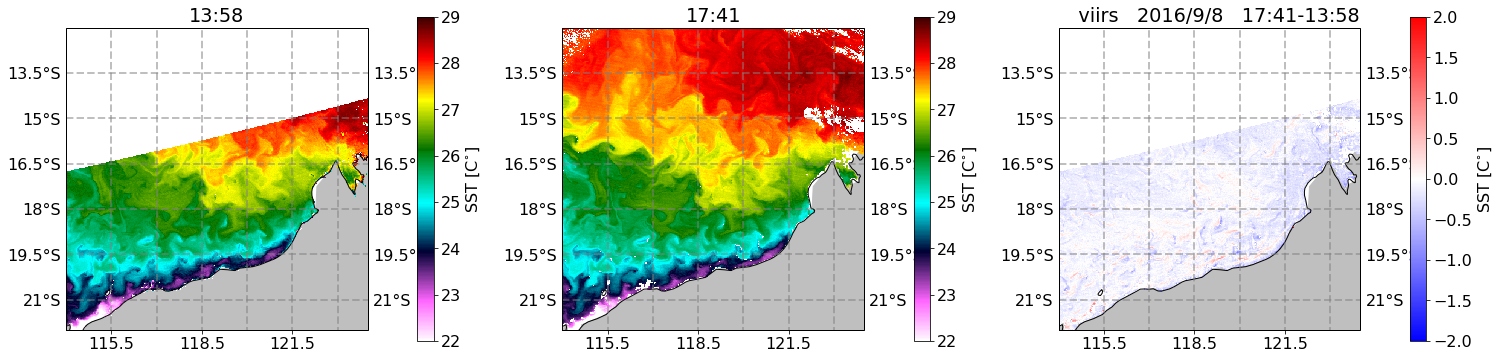

In [16]:
if(Region == 'AustraliaHW'):
    matplotlib.rcParams.update({'font.size': 16})
    str_h1=str(toplt_zoom.time.dt.hour.values[it1])+':'+str(toplt_zoom.time.dt.minute.values[it1])
    str_h2=str(toplt_zoom.time.dt.hour.values[it2])+':'+str(toplt_zoom.time.dt.minute.values[it2])
    str_date = [str_h1,str_h2]
    fig = plt.figure(figsize=(21,5))
    #plot SST
    ax = make_cartopy(1,3,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1,title = str_h1,lonticks = [115.5,118.5,121.5] )
    for i in range(irange1):   
        cs = ax.imshow(toplt_zoom[i+i01,:,:], origin='lower', extent=img_extent, transform=ccrs.PlateCarree(), vmin = vmin, vmax = vmax, cmap =csst)
    cbar = fig.colorbar(cs, ax=ax,pad=0.12)
    cbar.set_label(r'SST [C$^{\circ}$]')
    
    ax = make_cartopy(1,3,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=2,title = str_h2,lonticks = [115.5,118.5,121.5] )
    for i in range(irange2):
        cs = ax.imshow(toplt_zoom[i+i02,:,:], origin='lower', extent=img_extent, transform=ccrs.PlateCarree(), vmin = vmin, vmax = vmax, cmap =csst)

    cbar = fig.colorbar(cs, ax=ax,pad=0.12)
    cbar.set_label(r'SST [C$^{\circ}$]')
    tit = '   '+sensor + '   '+ str_date1+'   '+str_h2+'-'+str_h1
    ax = make_cartopy(1,3,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=3,title = tit, lonticks = [115.5,118.5,121.5] )
    cs = ax.imshow(dt_Temp, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(), cmap ='bwr',vmin=-2,vmax=2)
    cs = ax.imshow(dt_Temp2, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(), cmap ='bwr',vmin=-2,vmax=2)
    cs = ax.imshow(dt_Temp3, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(), cmap ='bwr',vmin=-2,vmax=2)
    if(day == '20160909'):
        dt_Temp3 = toplt_zoom[5,:,:]-toplt_zoom[it1,:,:]
        cs = ax.imshow(dt_Temp3, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(), cmap ='bwr',vmin=-2,vmax=2)
    cbar = fig.colorbar(cs, ax=ax, pad=0.12)
    cbar.set_label(r'SST [C$^{\circ}$]')
    plt.subplots_adjust(left=0.04,right=0.97,hspace=0.05,top=0.95, bottom =0.05)
    plt.savefig(graphdir+Region+os.sep+'SST_grad_t'+str_h2+'_'+str_h1+'.png')

In [17]:
dum = np.isfinite(dt_Temp.values).ravel()
itdum=dt_Temp.values.ravel()
itdum.shape

(250000,)

In [18]:
toplt_zoom.time

<xarray.DataArray 'time' (time: 5)>
array(['2016-09-08T01:28:03.000000000', '2016-09-08T13:58:03.000000000',
       '2016-09-08T17:40:14.000000000', '2016-09-08T17:41:39.000000000',
       '2016-09-08T17:43:05.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2016-09-08T01:28:03 2016-09-08T13:58:03 ...
Attributes:
    long_name:      reference time of field
    standard_name:  time
    axis:           T

In [19]:
if(Region == 'Mozamb2'):
    it = 0
    matplotlib.rcParams.update({'font.size': 18})
    str_h1=str(toplt_zoom.time.dt.hour.values[it1])+':'+str(toplt_zoom.time.dt.minute.values[it1])
    str_h2=str(toplt_zoom.time.dt.hour.values[it2])+':'+str(toplt_zoom.time.dt.minute.values[it2])
    str_date = [str_h1,str_h2]
    fig = plt.figure(figsize=(21,5))
    #plot SST
    for i in range(2):
        ax = make_cartopy(1,3,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=(i+1),title = str_date[i] )
        cs = ax.imshow(toplt_zoom[i,:,:], origin='lower', extent=img_extent, transform=ccrs.PlateCarree(), vmin = vmin, vmax = vmax, cmap =csst)
        cbar = fig.colorbar(cs, ax=ax,pad=0.12)
        cbar.set_label(r'SST [C$^{\circ}$]')
    sensor = list_file[it].rsplit(os.sep,4)[1]
    tit = '   '+sensor + '   '+ str_date1+'   '+str_h2+'-'+str_h1
    ax = make_cartopy(1,3,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=3,title = tit )
    cs = ax.imshow(dt_Temp, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(), cmap ='bwr',vmin=-2,vmax=2)
    cbar = fig.colorbar(cs, ax=ax, pad=0.12)
    cbar.set_label(r'SST [C$^{\circ}$]')
    plt.subplots_adjust(left=0.04,right=0.97,wspace=0.15,top=0.95, bottom =0.05)
    plt.savefig(graphdir+Region+os.sep+'SST_grad_t'+str_h2+'_'+str_h1+'.png')

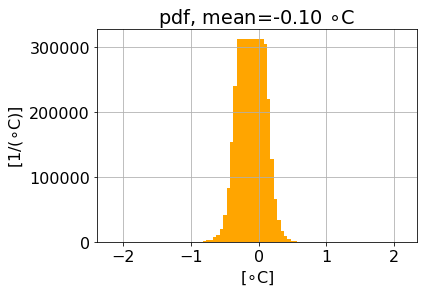

In [20]:
#plot histogram of deltaTemp

bins_e = np.arange(-2.,2.,.05)


dum_dt_temp = dt_Temp.values.ravel()
ifinite = np.isfinite(dum_dt_temp)

Temp_hist,bins_e = np.histogram(dum_dt_temp[ifinite],bins=bins_e,density=False)
bins_c = (bins_e[:-1]+bins_e[1:])*.5
dtTemp_pdf = Temp_hist/(np.diff(bins_e))

plt.figure()
ax = plt.gca()
#ax.bar(bins_c,np.log10(M2.uv_pdf),color='orange',width=.4)
ax.bar(bins_c,dtTemp_pdf,color='orange',width=.4)
ax.set_xlabel('[$\circ$C]')
ax.set_title('pdf, mean=%.2f $\circ$C ' %(dum_dt_temp[ifinite].mean()))
ax.set_ylabel('[1/($\circ$C)]')
ax.grid()
plt.subplots_adjust(left=0.21,right=0.95,hspace=0.2,wspace=0.1,top=0.92,bottom=0.18)
plt.savefig(graphdir+Region+os.sep+'Histogram_SST_grad_t'+str_h2+'_'+str_h1+'.png')

In [21]:
print(str(toplt_zoom.time.dt.hour.values[1])+':'+str(toplt_zoom.time.dt.minute.values[1]))

13:58


In [22]:
print(toplt_zoom.time)

<xarray.DataArray 'time' (time: 5)>
array(['2016-09-08T01:28:03.000000000', '2016-09-08T13:58:03.000000000',
       '2016-09-08T17:40:14.000000000', '2016-09-08T17:41:39.000000000',
       '2016-09-08T17:43:05.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2016-09-08T01:28:03 2016-09-08T13:58:03 ...
Attributes:
    long_name:      reference time of field
    standard_name:  time
    axis:           T


(114, 124, -22, -12)
HW


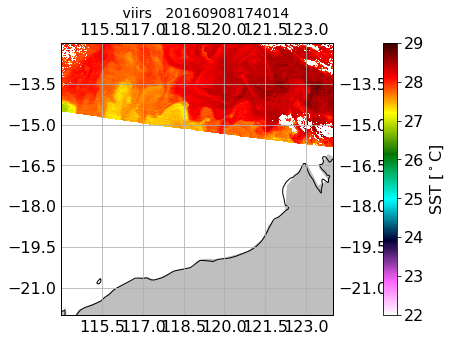

In [23]:

img_extent = (lonmin_z, lonmax_z, latmin_z, latmax_z)
print(img_extent)


fig = plt.figure(figsize=(9, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
cs = ax.imshow(toplt_zoom[it,:,:], origin='lower', extent=img_extent, transform=ccrs.PlateCarree(), vmin = vmin, vmax = vmax, cmap =csst)
if (Region == 'AustraliaHW'):
    print("HW")
    #cs = ax.imshow(toplt_zoom[it01,:,:], origin='lower', extent=img_extent, transform=ccrs.PlateCarree(), vmin = vmin, vmax = vmax, cmap =csst)
    #cs = ax.imshow(toplt_zoom[it02,:,:], origin='lower', extent=img_extent, transform=ccrs.PlateCarree(), vmin = vmin, vmax = vmax, cmap =csst)
cbar = fig.colorbar(cs, ax=ax, pad=0.1)
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.add_feature(cfeature.LAND, facecolor = '0.75')
ax.gridlines(draw_labels = True)
cbar.set_label('SST [$^\circ$C]')
name_fig = list_file[it].rsplit(os.sep,1)[1].rsplit('.',2)[0]+'_figure'
name_file = list_file[it].rsplit(os.sep,1)[1].rsplit('.',2)[0]
date_time = name_file[0:14]
sensor = list_file[it].rsplit(os.sep,4)[1]
plt.suptitle( '   '+sensor + '   '+ date_time, fontsize = 14)
plt.savefig(graphdir+Region+os.sep+name_fig+'_SST.png')
plt.show()

In [24]:
if (Region=='AustraliaHW'):
    dlon = toplt_zoom['lon'].diff('lon').mean()#ni
    dlat = toplt_zoom['lat'].diff('lat').mean()#nj
else:
    dlon = toplt_zoom['lon'].diff('ni').mean()#ni
    dlat = toplt_zoom['lat'].diff('nj').mean()#nj    

R_earth = 6378100 #earth radius m
deg2rad = np.pi/180
R_conv = R_earth*deg2rad
print(R_conv)

dy = (dlat*R_conv)
dx = dlon*R_conv*np.cos(deg2rad*toplt_zoom['lat'].mean())

dx = dx.values
dy = dy.values

print(dlon, dlat)
print(dx,dy)

111318.84502145034
<xarray.DataArray 'lon' ()>
array(0.02) <xarray.DataArray 'lat' ()>
array(0.02)
2129.093999377016 2226.376850665605


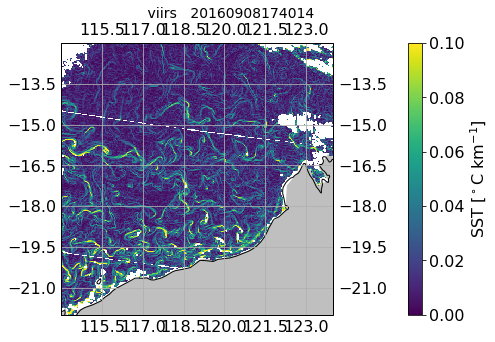

In [25]:

    


sobel_y, sobel_x = sobel_gradient(toplt_zoom[it,:,:], dx, dy)
sobel_grad =  np.sqrt(sobel_x**2+sobel_y**2)
if (Region == 'AustraliaHW'):
    sobel_y, sobel_x = sobel_gradient(toplt_zoom[it01,:,:], dx, dy)
    sobel_grad1 =  np.sqrt(sobel_x**2+sobel_y**2)
    sobel_y, sobel_x = sobel_gradient(toplt_zoom[it02,:,:], dx, dy)
    sobel_grad2 =  np.sqrt(sobel_x**2+sobel_y**2)
fig = plt.figure(figsize=(9, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
cs = ax.imshow(sobel_grad*1000, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_grad)
if (Region == 'AustraliaHW'):
    cs = ax.imshow(sobel_grad1*1000, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_grad)
    cs = ax.imshow(sobel_grad2*1000, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_grad)
cbar = fig.colorbar(cs, ax=ax, pad=0.15)
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.add_feature(cfeature.LAND, facecolor = '0.75')
ax.gridlines(draw_labels = True)
cbar.set_label('SST [$^\circ$C km$^{-1}$]')
name_file = list_file[it].rsplit(os.sep,1)[1].rsplit('.',2)[0]
date_time = name_file[0:14]
sensor = list_file[it].rsplit(os.sep,4)[1]
plt.suptitle( '   '+sensor + '   '+ date_time, fontsize = 14)
name_fig = list_file[it].rsplit(os.sep,1)[1].rsplit('.',2)[0]
plt.savefig(graphdir+os.sep+Region+os.sep+'GRADIENT_'+name_fig+'.png')

---

# Load HRET currents

In [26]:
#read tides
hret, constituents, omega = get_hret_ssh(constituents=['M2'], lonb=(lonmin_z, lonmax_z), latb=(latmin_z, latmax_z), hret=datadir_tides+'/Carrere_HRET_testing.nc',bathy=bathy)
print(hret)

M2 omega=1.405189e-04 rad/s, 1.932 cpd
/home2/pharos/othr/aponte/bathy/ETOPO2v2c_f4.nc
<xarray.Dataset>
Dimensions:    (latitude: 200, longitude: 201)
Coordinates:
  * longitude  (longitude) float64 114.0 114.1 114.1 114.2 114.2 114.2 114.3 ...
  * latitude   (latitude) float64 -22.0 -21.95 -21.9 -21.85 -21.8 -21.75 ...
Data variables:
    M2re       (latitude, longitude) float64 dask.array<shape=(200, 201), chunksize=(120, 201)>
    M2im       (latitude, longitude) float64 dask.array<shape=(200, 201), chunksize=(120, 201)>
    mask       (latitude, longitude) float64 dask.array<shape=(200, 201), chunksize=(120, 201)>
    h          (latitude, longitude) float64 -51.5 -6.001 -9.999 11.0 18.5 ...
Attributes:
    history:                  merged txa/j1a/j2a, txb/j1b, g1a, and e2a/n1b/s...
    resolution:               The spatial basis function coefficients are def...
    creator:                  Ed Zaron, ezaron@pdx.edu
    post-processing scripts:  baburu:NASA-Tides/Julia/; this file 

In [27]:
U, V, constituents, omega = get_hret_uv(constituents=['M2','K1'], lonb=(lonmin_z, lonmax_z), latb=(latmin_z, latmax_z), hret=datadir_tides+'/Carrere_HRET_testing.nc', bathy=bathy)

K1 omega=7.292116e-05 rad/s, 1.003 cpd
M2 omega=1.405189e-04 rad/s, 1.932 cpd
/home2/pharos/othr/aponte/bathy/ETOPO2v2c_f4.nc
7.292116514526208e-05


In [28]:
print(U)

<xarray.Dataset>
Dimensions:    (latitude: 199, longitude: 200)
Coordinates:
  * latitude   (latitude) float64 -22.0 -21.95 -21.9 -21.85 -21.8 -21.75 ...
  * longitude  (longitude) float64 114.0 114.1 114.1 114.2 114.2 114.2 114.3 ...
Data variables:
    M2         (latitude, longitude) complex128 dask.array<shape=(199, 200), chunksize=(119, 200)>
    K1         (latitude, longitude) complex128 dask.array<shape=(199, 200), chunksize=(119, 200)>


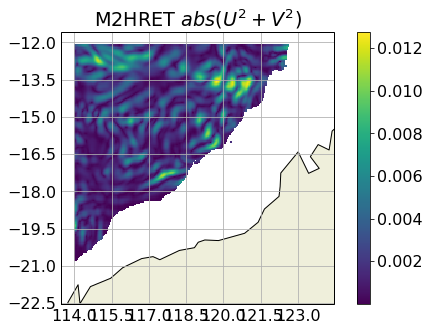

In [29]:
cst = 'M2'
hc=1000.

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection=crs)

#
toplt = np.abs(U['M2']**2+V['M2']**2)
toplt = toplt.where(hret['h']>hc)
toplt.plot()
ax.set_title(cst+r'HRET $abs(U^2+V^2)$')
gl = ax.gridlines(crs=crs, draw_labels=True) 
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines()
ax.add_feature(cfeature.LAND)
plt.savefig(graphdir+os.sep+Region+os.sep+'Wave_HRET'+name_fig+'_Wave_current'+cst+'.png')


---

## Regridding tides data

In [30]:
latitude_tides = U['latitude']
longitude_tides = U['longitude']

print(latitude_tides.shape)
print(longitude_tides.shape)

(199,)
(200,)


In [31]:
lat_sst = toplt_zoom.lat
lon_sst = toplt_zoom.lon

In [32]:
#Regriding tides data
# output grid has a larger coverage and finer resolution
grid_in = {'lon': longitude_tides,
            'lat': latitude_tides
           }

grid_out = {'lon': lon_sst,
            'lat': lat_sst
           }

In [33]:
#perform regridding
regridder = xe.Regridder(grid_in, grid_out, 'bilinear')
regridder.clean_weight_file()
regridder

Create weight file: bilinear_199x200_500x500.nc
Remove file bilinear_199x200_500x500.nc


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_199x200_500x500.nc 
Reuse pre-computed weights? False 
Input grid shape:           (199, 200) 
Output grid shape:          (500, 500) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

In [34]:
cst = 'M2'
U_out = regridder(U[cst])  # regrid a basic numpy array
V_out = regridder(V[cst]) 



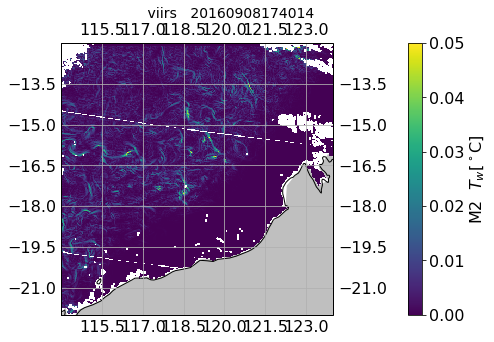

In [35]:


sobel_y, sobel_x = sobel_gradient(toplt_zoom[it,:,:], dx, dy)
Tc = (U_out*sobel_x+V_out*sobel_y)/(j*omega['M2']*cpd)
toplt = np.abs(Tc)
if (Region == 'AustraliaHW'):
    sobel_y, sobel_x = sobel_gradient(toplt_zoom[it01,:,:], dx, dy)
    Tc = (U_out*sobel_x+V_out*sobel_y)/(j*omega['M2']*cpd)
    toplt1 = np.abs(Tc)

    sobel_y, sobel_x = sobel_gradient(toplt_zoom[it02,:,:], dx, dy)
    Tc = (U_out*sobel_x+V_out*sobel_y)/(j*omega['M2']*cpd)
    toplt2 = np.abs(Tc)

fig = plt.figure(figsize=(9,5))
ax = plt.axes(projection=ccrs.PlateCarree())
cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
if (Region == 'AustraliaHW'):
    cs = ax.imshow(toplt1, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
    cs = ax.imshow(toplt2, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cbar = fig.colorbar(cs, ax=ax, pad = 0.15)
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.add_feature(cfeature.LAND, facecolor = '0.75')
ax.gridlines(draw_labels = True)
cbar.set_label(cst+  r'  $T_w[^\circ$C]')
name_file = list_file[it].rsplit(os.sep,1)[1].rsplit('.',2)[0]
date_time = name_file[0:14]
sensor = list_file[it].rsplit(os.sep,4)[1]
plt.suptitle( '   '+sensor + '   '+ date_time, fontsize = 14)
name_fig = list_file[it].rsplit(os.sep,1)[1].rsplit('.',2)[0]
plt.savefig(graphdir+os.sep+Region+os.sep+'Tc_'+name_fig+'_Twave.png')
plt.show()

In [36]:
#def make_cartopy(projection=ccrs.PlateCarree(), fig=plt.figure(), resolution='50m',nfig=1):
#    ax = fig.add_subplot(2,2,nfig,projection=projection)
#    ax.coastlines(resolution=resolution, color='k')
#    ax.add_feature(cfeature.LAND, facecolor = '0.75')
#    #ax.gridlines(draw_labels = True)
    #ax.set_title(Month_text)
#    gl = ax.gridlines(crs=projection, draw_labels=True,
#                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
#    gl.xlabels_top = False
#    gl.xformatter = LONGITUDE_FORMATTER
#    gl.yformatter = LATITUDE_FORMATTER

    # Only PlateCarree and Mercator plots are currently supported.
#    return ax

In [37]:
lons,lats = np.meshgrid(hret.longitude,hret.latitude)

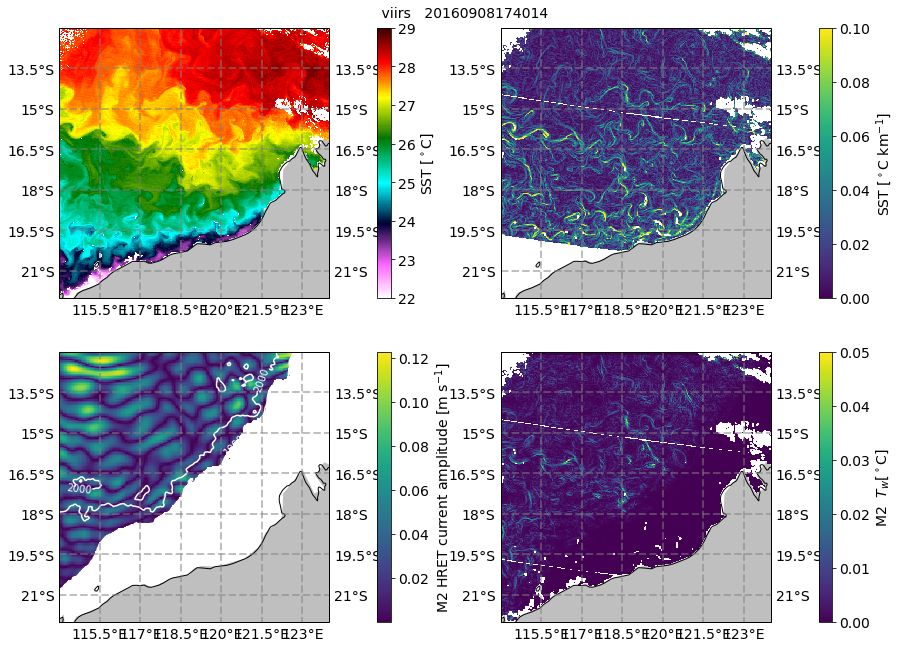

In [38]:
matplotlib.rcParams.update({'font.size': 14})

pad = 0.12
fig = plt.figure(figsize=(13,10))
#plot SST
ax = make_cartopy(2,2,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1)
cs = ax.imshow(toplt_zoom[it,:,:], origin='lower', extent=img_extent, transform=ccrs.PlateCarree(), vmin = vmin, vmax = vmax, cmap =csst)
if(Region=='AustraliaHW'):
    cs = ax.imshow(toplt_zoom[it01,:,:], origin='lower', extent=img_extent, transform=ccrs.PlateCarree(), vmin = vmin, vmax = vmax, cmap =csst)
    cs = ax.imshow(toplt_zoom[it02,:,:], origin='lower', extent=img_extent, transform=ccrs.PlateCarree(), vmin = vmin, vmax = vmax, cmap =csst)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
cbar.set_label('SST [$^\circ$C]')

#plot Grad SST
ax = make_cartopy(2,2,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=2)
cs = ax.imshow(sobel_grad*1000, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_grad)
if(Region=='AustraliaHW'):
    cs = ax.imshow(sobel_grad1*1000, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_grad)
    #cs = ax.imshow(sobel_grad2*1000, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_grad)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
cbar.set_label('SST [$^\circ$C km$^{-1}$]')

#plot wave current

ax = make_cartopy(2,2,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=3)
#toplt_U = np.abs(U['M2']**2+V['M2']**2)
toplt_U = np.sqrt(V[cst].real**2+V[cst].real**2)
toplt_U = toplt_U.where(hret['h']>hc)
cs = ax.imshow(toplt_U, origin='lower', extent=img_extent, transform=ccrs.PlateCarree())
levels=[100,1000,2000]
ccont = ax.contour(lons,lats,hret['h'],levels, extent=img_extent, transform=ccrs.PlateCarree(),colors='w')
plt.clabel(ccont, inline=1, fontsize=10,fmt='%.0f')
#toplt.plot()
#ax.set_title(cst+r'HRET $abs(U^2+V^2)$')
cbar = fig.colorbar(cs, ax=ax, pad=pad)
cbar.set_label(cst+r' HRET current amplitude [m s$^{-1}$]')


#plot wave SST
ax = make_cartopy(2,2,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=4)

cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
if(Region=='AustraliaHW'):
    cs = ax.imshow(toplt1, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
    cs = ax.imshow(toplt2, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
cbar.set_label(cst+  r'  $T_w[^\circ$C]')


name_file = list_file[it].rsplit(os.sep,1)[1].rsplit('.',2)[0]
date_time = name_file[0:14]
sensor = list_file[it].rsplit(os.sep,4)[1]
plt.suptitle( '   '+sensor + '   '+ date_time, fontsize = 14)
name_fig = list_file[it].rsplit(os.sep,1)[1].rsplit('.',2)[0]
plt.subplots_adjust(left=0.05,right=0.95,hspace=0.2,wspace=0.1,top=0.95)
plt.savefig(graphdir+os.sep+Region+os.sep+'Figure_HRET_'+cst+Region+'_'+name_fig+'.png')


---

# Load FES currents

In [39]:
# load fes currents for one constituent

U, V, constituents, omega = get_fes_uv(constituents=['M2'], lonb=(lonmin_z, lonmax_z), latb=(latmin_z, latmax_z), fes=datadir_tides2,bathy=False)
print(U)

7.292116514526208e-05
M2 omega=1.405189e-04 rad/s, 1.932 cpd
<xarray.Dataset>
Dimensions:    (lat: 161, lon: 161)
Coordinates:
  * lat        (lat) float32 -22.0 -21.9375 -21.875 -21.8125 -21.75 -21.6875 ...
  * lon        (lon) float32 114.0 114.0625 114.125 114.1875 114.25 114.3125 ...
Data variables:
    M2Ua       (lat, lon) float64 dask.array<shape=(161, 161), chunksize=(161, 161)>
    M2Ug       (lat, lon) float64 dask.array<shape=(161, 161), chunksize=(161, 161)>
    longitude  (lon, lat) float32 114.0 114.0 114.0 114.0 114.0 114.0 114.0 ...
    latitude   (lat, lon) float32 -22.0 -22.0 -22.0 -22.0 -22.0 -22.0 -22.0 ...


In [40]:
print(omega)

{'M2': 1.9322736167999999}


<xarray.DataArray 'M2Ug' (lat: 161, lon: 161)>
dask.array<shape=(161, 161), dtype=float64, chunksize=(161, 161)>
Coordinates:
  * lat      (lat) float32 -22.0 -21.9375 -21.875 -21.8125 -21.75 -21.6875 ...
  * lon      (lon) float32 114.0 114.0625 114.125 114.1875 114.25 114.3125 ...
Attributes:
    units:         degrees
    grid_mapping:  crs
    long_name:     Eastward sea water velocity phaselag due to non equilibriu...
<xarray.DataArray (lat: 161, lon: 161)>
array([[      nan,       nan, 20.416421, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [12.088808,       nan, 40.707386, ...,       nan,       nan,       nan],
       ...,
       [ 2.813598,  2.83132 ,  2.855435, ..., 29.749393, 30.244509, 29.431468],
       [ 2.843774,  2.839578,  2.835516, ..., 28.166188, 27.749318, 28.496171],
       [ 2.828848,  2.82016 ,  2.815996, ..., 26.061424, 25.662657, 26.243461]])
Coordinates:
  * lat      (lat) float32 

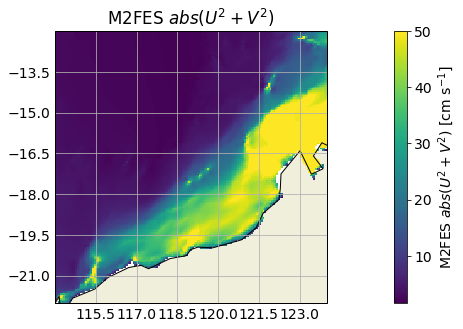

In [41]:
cst = 'M2'
hc=1000.

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection=crs)

u = U[cst+'Ua']* np.exp(j*np.radians(U[cst+'Ug']))
v = V[cst+'Va']* np.exp(j*np.radians(V[cst+'Vg']))
print(U[cst+'Ug'])
#
toplt = np.sqrt(np.abs(u)**2+np.abs(v)**2)
print(toplt)
cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax = 50)
cbar = fig.colorbar(cs, ax=ax, pad=0.15)
cbar.set_label(cst+r'FES $abs(U^2+V^2)$ [cm s$^{-1}$]')
#toplt = toplt.where(hret['h']>hc)
#toplt.plot()
ax.set_title(cst+r'FES $abs(U^2+V^2)$')
gl = ax.gridlines(crs=crs, draw_labels=True) 
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines()
ax.add_feature(cfeature.LAND)
plt.savefig(graphdir+os.sep+Region+os.sep+'Wave_FES'+name_fig+'_Wave_current'+cst+'.png')

## Regridding tides data

In [42]:
latitude_tides = U['latitude'][:,1]
longitude_tides = U['longitude'][:,1]

print(latitude_tides.shape)
print(longitude_tides.shape)

(161,)
(161,)


In [43]:
#Regriding tides data
# output grid has a larger coverage and finer resolution
grid_in = {'lon': longitude_tides,
            'lat': latitude_tides
           }

grid_out = {'lon': lon_sst,
            'lat': lat_sst
           }

In [44]:
#perform regridding
regridder = xe.Regridder(grid_in, grid_out, 'bilinear')
regridder.clean_weight_file()
regridder

Create weight file: bilinear_161x161_500x500.nc
Remove file bilinear_161x161_500x500.nc


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_161x161_500x500.nc 
Reuse pre-computed weights? False 
Input grid shape:           (161, 161) 
Output grid shape:          (500, 500) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

In [45]:
U_out_a = regridder(U[cst+'Ua'])*1e-2  # regrid a basic numpy array
V_out_a = regridder(V[cst+'Va'])*1e-2 # convert cm/s to m/s

U_out_g = regridder(U[cst+'Ug']) 
V_out_g = regridder(V[cst+'Vg']) 

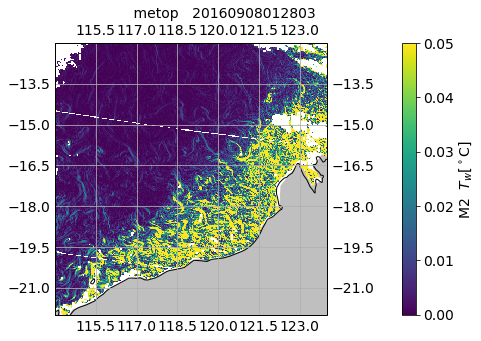

In [46]:
U_out = U_out_a* np.exp(-j*np.radians(U_out_g))
V_out = V_out_a* np.exp(-j*np.radians(V_out_g))

sobel_y, sobel_x = sobel_gradient(toplt_zoom[it,:,:], dx, dy)
Tc = (U_out*sobel_x+V_out*sobel_y)/(j*omega['M2']*cpd)
toplt = np.abs(Tc)
if (Region == 'AustraliaHW'):
    sobel_y, sobel_x = sobel_gradient(toplt_zoom[it01,:,:], dx, dy)
    Tc = (U_out*sobel_x+V_out*sobel_y)/(j*omega['M2']*cpd)
    toplt1 = np.abs(Tc)

    sobel_y, sobel_x = sobel_gradient(toplt_zoom[it02,:,:], dx, dy)
    Tc = (U_out*sobel_x+V_out*sobel_y)/(j*omega['M2']*cpd)
    toplt2 = np.abs(Tc)

fig = plt.figure(figsize=(9,5))
ax = plt.axes(projection=ccrs.PlateCarree())
cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
if (Region == 'AustraliaHW'):
    cs = ax.imshow(toplt1, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
    cs = ax.imshow(toplt2, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cbar = fig.colorbar(cs, ax=ax, pad = 0.15)
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.add_feature(cfeature.LAND, facecolor = '0.75')
ax.gridlines(draw_labels = True)
cbar.set_label(cst+  r'  $T_w[^\circ$C]')
name_file = list_file[0].rsplit(os.sep,1)[1].rsplit('.',2)[0]
date_time = name_file[0:14]
sensor = list_file[0].rsplit(os.sep,4)[1]
plt.suptitle( '   '+sensor + '   '+ date_time, fontsize = 14)
name_fig = list_file[0].rsplit(os.sep,1)[1].rsplit('.',2)[0]
plt.savefig(graphdir+os.sep+Region+os.sep+'Tc_'+name_fig+cst+'_'+'_TwaveFES.png')


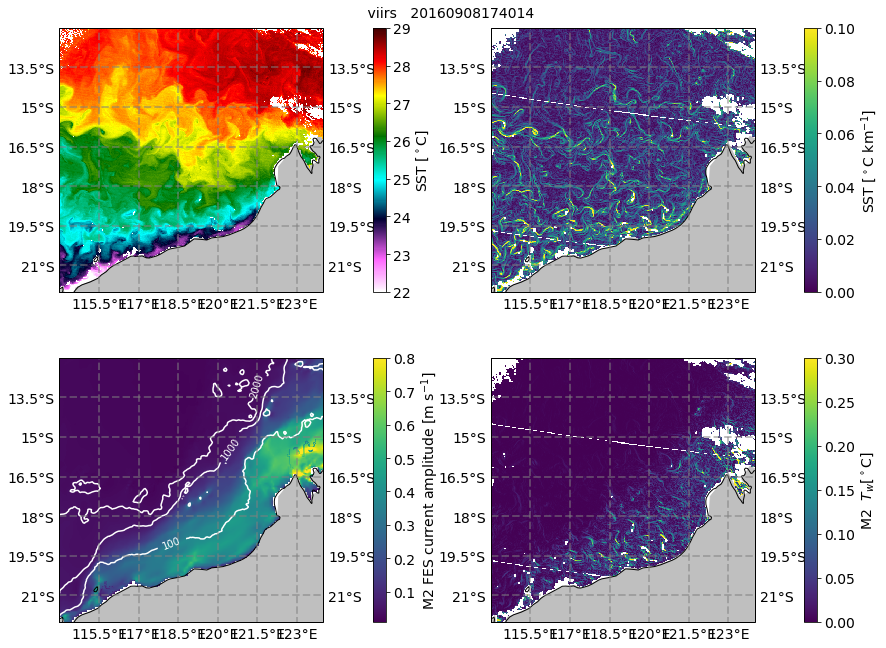

In [47]:
vmax_tw = 0.3
pad = 0.12

fig = plt.figure(figsize=(13,10))
#plot SST
ax = make_cartopy(2,2,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1)
cs = ax.imshow(toplt_zoom[it,:,:], origin='lower', extent=img_extent, transform=ccrs.PlateCarree(), vmin = vmin, vmax = vmax, cmap =csst)
if(Region=='AustraliaHW'):
    cs = ax.imshow(toplt_zoom[it01,:,:], origin='lower', extent=img_extent, transform=ccrs.PlateCarree(), vmin = vmin, vmax = vmax, cmap =csst)
    cs = ax.imshow(toplt_zoom[it02,:,:], origin='lower', extent=img_extent, transform=ccrs.PlateCarree(), vmin = vmin, vmax = vmax, cmap =csst)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
cbar.set_label('SST [$^\circ$C]')

#plot Grad SST
ax = make_cartopy(2,2,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=2)
cs = ax.imshow(sobel_grad*1000, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_grad)
if(Region=='AustraliaHW'):
    cs = ax.imshow(sobel_grad1*1000, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_grad)
    cs = ax.imshow(sobel_grad2*1000, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_grad)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
cbar.set_label('SST [$^\circ$C km$^{-1}$]')

#plot wave current
ax = make_cartopy(2,2,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=3)
toplt_U = np.sqrt(U_out.real**2+V_out.real**2)
cs = ax.imshow(toplt_U, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=0.8)
#toplt.plot()
#ax.set_title(cst+r'HRET $abs(U^2+V^2)$')
cbar = fig.colorbar(cs, ax=ax, pad=pad)
cbar.set_label(cst+r' FES current amplitude [m s$^{-1}$]')
levels=[100,1000,2000]
ccont = ax.contour(lons,lats,hret['h'],levels, extent=img_extent, transform=ccrs.PlateCarree(),colors='w')
plt.clabel(ccont, inline=1, fontsize=10,fmt='%.0f')


#plot wave SST
ax = make_cartopy(2,2,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=4)

cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
if(Region=='AustraliaHW'):
    cs = ax.imshow(toplt1, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
    cs = ax.imshow(toplt2, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
cbar.set_label(cst+  r'  $T_w[^\circ$C]')


name_file = list_file[it].rsplit(os.sep,1)[1].rsplit('.',2)[0]
date_time = name_file[0:14]
sensor = list_file[it].rsplit(os.sep,4)[1]
plt.suptitle( '   '+sensor + '   '+ date_time, fontsize = 14)
name_fig = list_file[it].rsplit(os.sep,1)[1].rsplit('.',2)[0]
plt.subplots_adjust(left=0.05,right=0.95,hspace=0.25,wspace=0.05,top=0.95)
plt.savefig(graphdir+os.sep+Region+os.sep+'Figure_FES_'+cst+Region+'_'+name_fig+'.png')

---

## Read MW

In [48]:
from amsr2_daily import AMSR2daily
from amsr2_averaged import AMSR2averaged
if (Region == 'Mozamb2'):
    filenameMW3d = 'f34_20140605v8_d3d.gz' 
if Region == 'AustraliaHW':
    filenameMW3d = 'f34_20160908v8_d3d.gz'

In [49]:
def read_data(filename):
    #dataset = AMSR2daily(filename, missing=missing)
    dataset = AMSR2averaged(filename)
    if not dataset.variables: sys.exit('problem reading file')
    return dataset

In [50]:
fileMW3d = '/home3/homedir7/perso/cgonzale/IWAVE/data/L3_AMSR2/NortwestAustralia/f34_20140605v8_d3d.gz'
dataset = read_data(fileMW3d)


In [51]:
sst_mw3d = dataset.variables['sst']
lat_mw3d = dataset.variables['latitude']
lon_mw3d = dataset.variables['longitude']

In [52]:


dsMW = xr.Dataset({'sst': (('lat', 'lon'), sst_mw3d)},
                {'lat': lat_mw3d, 'lon': lon_mw3d})
print(dsMW)

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440)
Coordinates:
  * lat      (lat) float64 -89.88 -89.62 -89.38 -89.12 -88.88 -88.62 -88.38 ...
  * lon      (lon) float64 0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875 ...
Data variables:
    sst      (lat, lon) float64 255.0 255.0 255.0 255.0 255.0 255.0 255.0 ...


In [53]:
toplt=dsMW['sst']
toplt_zoom_MW = toplt.where(toplt['lon']>=lonmin_z, drop=True)
toplt_zoom_MW = toplt_zoom_MW.where(toplt_zoom_MW['lon']<=lonmax_z, drop=True)
toplt_zoom_MW = toplt_zoom_MW.where(toplt_zoom_MW['lat']<=latmax_z, drop=True)
toplt_zoom_MW = toplt_zoom_MW.where(toplt_zoom_MW['lat']>=latmin_z, drop=True)
print(toplt_zoom_MW)
print(toplt_zoom_MW.min(),toplt_zoom_MW.max())
sst_mask = toplt_zoom_MW.where(toplt_zoom_MW <= 100)
print(sst_mask)

<xarray.DataArray (lat: 40, lon: 40)>
array([[255.  , 253.  , 255.  , ..., 255.  , 255.  , 255.  ],
       [251.  , 251.  , 251.  , ..., 255.  , 255.  , 255.  ],
       [251.  , 251.  ,  27.3 , ..., 255.  , 255.  , 255.  ],
       ...,
       [ 28.95,  28.95,  29.1 , ...,  28.95,  28.8 ,  28.95],
       [ 29.55,  29.25,  29.1 , ...,  29.1 ,  29.1 ,  28.8 ],
       [ 29.1 ,  29.4 ,  29.1 , ...,  28.95,  28.95,  28.95]])
Coordinates:
  * lat      (lat) float64 -21.88 -21.62 -21.38 -21.12 -20.88 -20.62 -20.38 ...
  * lon      (lon) float64 114.1 114.4 114.6 114.9 115.1 115.4 115.6 115.9 ...
<xarray.DataArray ()>
array(26.85) <xarray.DataArray ()>
array(255.)
<xarray.DataArray (lat: 40, lon: 40)>
array([[  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan, 27.3 , ...,   nan,   nan,   nan],
       ...,
       [28.95, 28.95, 29.1 , ..., 28.95, 28.8 , 28.95],
       [29.55, 29.25, 29.1 , ..., 29.1 , 29.1 , 28.8 ],
      

In [54]:
dlon = toplt_zoom_MW['lon'].diff('lon').mean()#ni
dlat = toplt_zoom_MW['lat'].diff('lat').mean()#nj    

R_earth = 6378100 #earth radius m
deg2rad = np.pi/180
R_conv = R_earth*deg2rad
print(R_conv)

dy = (dlat*R_conv)
dx = dlon*R_conv*np.cos(deg2rad*toplt_zoom_MW['lat'].mean())

dx = dx.values
dy = dy.values

print(dlon.values, dlat.values)
print(dx,dy)

111318.84502145034
0.25 0.25
26613.685230581257 27829.711255362585


In [55]:
dy=np.abs(dy)
sobel_y, sobel_x = sobel_gradient(sst_mask, dx, dy)
sobel_grad_MW =  np.sqrt(sobel_x**2+sobel_y**2)

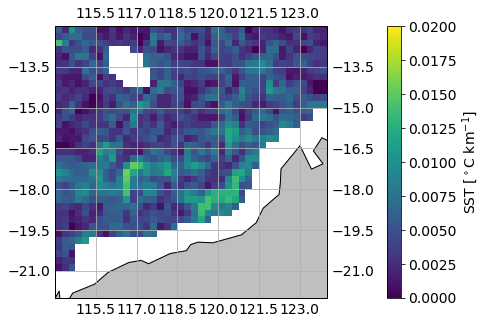

In [56]:
vmax_grad = 0.02
fig = plt.figure(figsize=(9, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
#hdl = ax.contourf(toplt_zoom_MW.lon,toplt_zoom_MW.lat,np.squeeze(sobel_grad_MW)*1000,nlevels, \
#        transform = ccrs.PlateCarree(),extent=img_extent,cmap='viridis',vmax=vmax_grad)
cs = ax.imshow(sobel_grad_MW*1000, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_grad)
ax.coastlines(resolution='110m', color ='k' )
ax.add_feature(cfeature.LAND, facecolor = '0.75')
ax.gridlines(draw_labels = True)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
#m = plt.cm.ScalarMappable(cmap='viridis')
#m.set_array(sst_z)
#m.set_clim(0, vmax_grad)
#cb=plt.colorbar(m, boundaries=np.arange(0,vmax_grad+0.01,.005),pad= pad)
cbar.set_label('SST [$^\circ$C km$^{-1}$]')

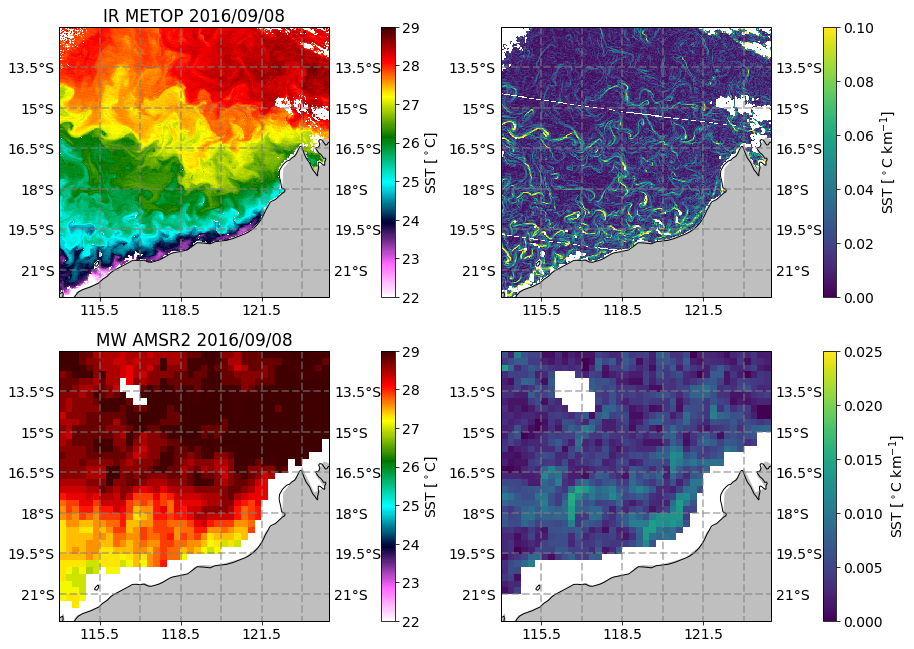

In [57]:
matplotlib.rcParams.update({'font.size': 14})
vmax_grad =0.1
pad = 0.13

if(Region == 'Mozamb2'):
    title_MW = 'MW AMSR2 2014/06/05'
if(Region == 'AustraliaHW'):
    title_MW = 'MW AMSR2 2016/09/08'

fig = plt.figure(figsize=(13,10))
#plot IR SST
if(Region == 'AustraliaHW'):
    ax = make_cartopy(2,2,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1,title = 'IR METOP 2016/09/08',lonticks = [115.5,118.5,121.5])
    cs = ax.imshow(toplt_zoom[it01,:,:], origin='lower', extent=img_extent, transform=ccrs.PlateCarree(), vmin = vmin, vmax = vmax, cmap =csst)
    cs = ax.imshow(toplt_zoom[it02,:,:], origin='lower', extent=img_extent, transform=ccrs.PlateCarree(), vmin = vmin, vmax = vmax, cmap =csst)
elif (Region == 'Mozamb2'):
    ax = make_cartopy(2,2,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1,title = 'IR METOP 2014/06/05')        
cs = ax.imshow(toplt_zoom[it,:,:], origin='lower', extent=img_extent, transform=ccrs.PlateCarree(), vmin = vmin, vmax = vmax, cmap =csst)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
cbar.set_label('SST [$^\circ$C]')

#plot Grad IR SST
if(Region == 'AustraliaHW'):
    ax = make_cartopy(2,2,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=2,lonticks = [115.5,118.5,121.5])
    cs = ax.imshow(sobel_grad1*1000, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_grad)
    cs = ax.imshow(sobel_grad2*1000, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_grad)
elif (Region == 'Mozamb2'):
    ax = make_cartopy(2,2,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=2)                 
cs = ax.imshow(sobel_grad*1000, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_grad)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
cbar.set_label('SST [$^\circ$C km$^{-1}$]')

#plot MW SST
if(Region == 'AustraliaHW'):
    ax = make_cartopy(2,2,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=3,title=title_MW,lonticks = [115.5,118.5,121.5])
elif(Region == 'Mozamb2'):
    ax = make_cartopy(2,2,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=3,title=title_MW)
cs = ax.imshow(sst_mask, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap=csst)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
cbar.set_label('SST [$^\circ$C]')

#plot Grad MW SST
ax = make_cartopy(2,2,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=4,lonticks = [115.5,118.5,121.5])
cs = ax.imshow(sobel_grad_MW*1000, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_grad/4)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
cbar.set_label('SST [$^\circ$C km$^{-1}$]')

plt.subplots_adjust(left=0.05,right=0.95,hspace=0.2,wspace=0.1,top=0.95)
plt.savefig(graphdir+os.sep+'Figure_MW_IR_'+Region+'.png')

---

# Load HRET currents and plot global map

In [58]:
#read tides
if(False):
    hret, constituents, omega = get_hret_ssh(constituents=['M2'], hret=datadir_tides+'/Carrere_HRET_testing.nc',bathy=bathy)
    print(hret)

In [59]:
if(False):
    U, V, constituents, omega = get_hret_uv(constituents=['M2'],  hret=datadir_tides+'/Carrere_HRET_testing.nc', bathy=bathy)

In [60]:
if(False):
    hc=1000.
    cst = 'M2'

    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111, projection=crs)
    #
    #toplt = np.abs(hret[cst+'re']+j*hret[cst+'im'])
    toplt = np.sqrt(U['M2'].real**2+V['M2'].real**2)
    toplt = toplt.where(hret['h']>hc)
    toplt.plot(cmap=plt.get_cmap('CMRmap_r'),vmax=0.1)
    #ax.set_title(cst+' abs(eta_r +i eta_i)')
    ax.set_title(r'M2 current amplitudes (approx, h>1000m)')
    gl = ax.gridlines(crs=crs, draw_labels=True) 
    gl.xlabels_top = False
    gl.ylabels_right = False
    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor = '0.75')
    plt.subplots_adjust(left=0.05,right=0.95,top=0.95)
    plt.savefig(graphdir+os.sep+'hret_uv_amplitude_map_M2.png')